## import packages

In [1]:
import sys
import time
from pathlib import Path
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.calibration import CalibrationDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pickle 

from sklearn.model_selection import StratifiedKFold

## set up for imports of .py modules by adding path to sys.path

In [2]:
# Get the current working directory
cwd = Path(os.getcwd())

# Set the current working directory to its parent
parent_cwd = cwd.parent
os.chdir(parent_cwd)

# Verify the change
print(f"Current working directory changed to: {os.getcwd()}")

Current working directory changed to: /Users/nelsonfarrell/Documents/Northeastern/5220/final_project


## import python modules

In [3]:
import utils.sml_utils as sml_utils
import utils.bin_class_utils as class_utils
import utils.glue_old_to_new as gotn
import utils.assign_and_lab_utils as al_utils
import utils.classification_utils as class_utils_2
import utils.reg_model_selection_utils as reg_ms_utils

## helpful functions

In [4]:
print('no functions')  # all helpful functions should go in this cell to preserve the cell count

no functions


## parameters

In [5]:
# path to data
path_to_data = 'data/data_splits/train_df.csv'
task = 'classification'

# step 1 parameters - check for missingness in target vector
target_attr = 'Segmentation'
class_labels = ['B', 'D']

# step 2 parameters

# step 3 parameters - train/test split
test_size = 0.20
train_test_split_random_state = 42

# step 4 parameters - train/validation split
train_validation_split = False
val_size = 0.30
train_validation_split_random_state = 42

# step 4.25 parameters - ttrain/probability calibration split
train_prob_cal_split = True  # used to calibrate classifier probability
train_prob_cal_split_random_state = 42
train_prob_cal_split_size = 0.20

# step 4.5 parameters - train/classification threshold tuning split
train_class_threshold_tune_split = True  # used to set the classification threshold
train_class_threshold_tune_split_random_state = 42
train_class_threshold_tune_split_size = 0.20

# step 5 parameters - identify attributes with missingness above threshold
missingness_threshold = 0.20

# step 11 parameters - build a composite estimator
sgd_class_random_state = 42
target_encoder_random_state = 42
class_weight = 'balanced'
rf_random_state = 42
dtc_stub_random_state = 42
adaboost_random_state = 42
svc_random_state = 42

# transformer parameters
nominal_imputer_strategy = "most_frequent"
numerical_imputer_strategy = "mean"

# step 12 parameters - model selection / model assessment parameters cross validation parameters
scoring = ['neg_log_loss']  # must be in a list even if only one scoring metric
kwargs = {'return_indices': False}  # if true the indices of the cross validation split are returned
max_iter = 1000  # max number of epochs for SGDClassifier

# step 12 parameters - maximal control k-fold cross validation splitter parameters
kfold_n_splits = 10  # number of folds in k-fold cross validation
kfold_shuffle = True
kfold_random_state = 42

# step 14 parameters - tune hyperparameters of short-listed composite estimators
gs_cv_kfold_n_splits = 10
gs_cv_kfold_shuffle = True
gs_cv_kfold_random_state = 24
show_all_params = True
speed_up = False  # if True random stratified sample taken before GridSearchCV
frac = 0.10  # fraction taken for speed up
spd_up_random_state = 42  # speed up random state

# step 16 parameters - calibrate the classifiers
calibrate_classifiers = True
frac_of_val_for_cal = 0.5  # 1 - frac to validate cal

# step 18 parameters - model selection - configured for no model selection
script_select = False  # default = False - True if you want to let the script select the model with the lowest log loss out of GridsearchCV
hand_select = False  # default = False - if True you must select a model by hand and identify the model row index in grid_search_cv_results_df
hand_select_index = None # do not change this line
if hand_select:
    hand_select_index = None  # default = None - if hand select enter best model index from grid_search_cv_results_df

# step 19 - tune classification threshold
classification_threshold = None  # default = None

## set up to time script run time

In [6]:
start = time.time()

## read in the data and get the size of the data

In [7]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(6454, 12)


,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,917,465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6,A
1,3398,462903,Male,Yes,72,Yes,Entertainment,NaN,Average,2.0,Cat_6,B
2,2045,467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6,B
3,8060,463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6,A
4,4604,459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7,A


## out of pipeline preprocessing

### These operations cannot be completed in the scikit-learn pipeline.

### They should be identified and passed on the the data engineer as tasks conducted during extract/transform/load (ETL) if the model goes to production.

## 1. check for missingness in target vector and dedup

In [8]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(6454, 12)
(6454, 12)


In [9]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(6454, 12)
(6454, 12)


## 2. label binarize

In [10]:
# convert to binary class by dropping two classes from dataset
df = df[df['Segmentation'].isin(class_labels)]


In [11]:
df.shape

(3300, 12)

In [12]:
if pd.api.types.infer_dtype(df[target_attr]) == 'string':
    df, le_name_mapping = class_utils.label_binarize_binary(df, target_attr, print_results=True)
else:
    print(f'df[target_attr] is not a string attribute')


df[target_attr] is a string attribute

df.loc[0:5, target_attr]:
1    B
2    B
Name: Segmentation, dtype: object

Segmentation
D    0.549697
B    0.450303
Name: proportion, dtype: float64

label encode df[target_attr]

after label encoding df[target_attr]

Segmentation
0.0    0.549697
1.0    0.450303
Name: proportion, dtype: float64

df.loc[0:5, target_attr]:
1    1.0
2    1.0
Name: Segmentation, dtype: float64

lb_name_mapping: {0: 'D', 1: 'B'}


## 3. train/test split

In [13]:
train_cap_x_df, train_y_df = \
    sml_utils.perform_the_train_test_split(
    df, 
    test_size, 
    train_test_split_random_state, 
    val=False,
    stratify=True
)

*************************

df.shape:
(3300, 12)

target class fractional balance:
Segmentation
0.0    0.549697
1.0    0.450303
Name: count, dtype: float64

*************************

train_df.csv:
(2640, 11) (2640, 1)

target class fractional balance:
Segmentation
0.0    0.549621
1.0    0.450379
Name: count, dtype: float64

*************************

test_df.csv
(660, 11) (660, 1)

target class fractional balance:
Segmentation
0.0    0.55
1.0    0.45
Name: count, dtype: float64


## 4. train/validation split

In [14]:
if train_validation_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            val_size, 
            train_validation_split_random_state, 
            val=True,
            stratify=True
    )

## 4.25 train / probability calibration split

In [15]:
if train_prob_cal_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            train_prob_cal_split_size, 
            train_prob_cal_split_random_state, 
            prob_cal=True,
            stratify=True
    )

*************************

df.shape:
(2640, 12)

target class fractional balance:
Segmentation
0.0    0.549621
1.0    0.450379
Name: count, dtype: float64

*************************

train_df.csv:
(2112, 11) (2112, 1)

target class fractional balance:
Segmentation
0.0    0.549716
1.0    0.450284
Name: count, dtype: float64

*************************

prob_cal_set_df.csv
(528, 11) (528, 1)

target class fractional balance:
Segmentation
0.0    0.549242
1.0    0.450758
Name: count, dtype: float64


## 4.5 train / classification threshold tuning split

In [16]:
if train_class_threshold_tune_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            train_class_threshold_tune_split_size, 
            train_class_threshold_tune_split_random_state, 
            classification_threshold=True,
            stratify=True
    )

*************************

df.shape:
(2112, 12)

target class fractional balance:
Segmentation
0.0    0.549716
1.0    0.450284
Name: count, dtype: float64

*************************

train_df.csv:
(1689, 11) (1689, 1)

target class fractional balance:
Segmentation
0.0    0.549438
1.0    0.450562
Name: count, dtype: float64

*************************

class_thresh_set_df.csv
(423, 11) (423, 1)

target class fractional balance:
Segmentation
0.0    0.550827
1.0    0.449173
Name: count, dtype: float64


## 5. identify attributes with  missingness above threshold

In [17]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

index missingness = 0.0
ID missingness = 0.0
Gender missingness = 0.0
Ever_Married missingness = 0.019538188277087035
Age missingness = 0.0
Graduated missingness = 0.010657193605683837
Profession missingness = 0.021906453522794554
Work_Experience missingness = 0.12196566015393724
Spending_Score missingness = 0.0
Family_Size missingness = 0.046773238602723505
Var_1 missingness = 0.008880994671403197

missingness_drop_list:
[]


## 6. identify non machine learning attributes

In [18]:
sml_utils.check_for_complete_unique_attrs(train_cap_x_df)

the data frame has 1689 rows

index has 1689 unique values and is dtype int64 examine more closely
ID has 1689 unique values and is dtype int64 examine more closely
Gender has 2 unique values and is dtype object 
Ever_Married has 2 unique values and is dtype object 
Age has 67 unique values and is dtype int64 
Graduated has 2 unique values and is dtype object 
Profession has 9 unique values and is dtype object 
Work_Experience has 15 unique values and is dtype float64 
Spending_Score has 3 unique values and is dtype object 
Family_Size has 9 unique values and is dtype float64 
Var_1 has 7 unique values and is dtype object 


['index', 'ID']

In [19]:
non_ml_attr_list = ['index', 'ID']

## 7. identify attributes to exclude from machine learning

In [20]:
train_cap_x_df.columns

Index(['index', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [21]:
ml_attr_drop_list = ['Work_Experience', 'Var_1', 'Gender', 'Family_Size', 'Ever_Married']

## 8. establish machine learning attribute configuration

In [22]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['index',
 'ID',
 'Work_Experience',
 'Var_1',
 'Gender',
 'Family_Size',
 'Ever_Married']

In [23]:
train_cap_x_df.columns

Index(['index', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [24]:
df.dtypes

index                int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation       float64
dtype: object

In [25]:
# identify the remaining numerical attributes to be used in machine learning and enter them into the 
# numerical_attr list below.

numerical_attr = ["Age"]

# identify the remaining nominal attributes to be used in machine learning and enter them into the 
# nominal_attr list below.

nominal_attr = ['Graduated', 'Profession', 'Spending_Score']

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['index', 'ID', 'Work_Experience', 'Var_1', 'Gender', 'Family_Size', 'Ever_Married']

numerical_attr: ['Age']
nominal_attr: ['Graduated', 'Profession', 'Spending_Score']

number of machine learning attributes: 4

numerical_attr and nominal_attr: ['Age', 'Graduated', 'Profession', 'Spending_Score']


## 9. assess target attribute imbalance

In [26]:
train_y_df[target_attr].unique().tolist()

[0.0, 1.0]

In [27]:
train_y_df[target_attr].value_counts(normalize=True)

Segmentation
0.0    0.549438
1.0    0.450562
Name: proportion, dtype: float64

## 10. steps to deal with target attribute imbalance if required

To be completed later.

## 11. build default composite estimators

### build a dictionary of default estimators

In [28]:
estimators_list = [

    ('SGDClassifier', SGDClassifier(
        loss='log_loss',  # 'hinge'
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=max_iter, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=-1,  # None
        random_state=sgd_class_random_state,  # None
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=True,  # False,
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=class_weight,  # None
        warm_start=False, 
        average=False)
    ),

    ('RandomForestClassifier', RandomForestClassifier(
        n_estimators=100,
        criterion='gini', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features='sqrt', 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=-1,  # None, 
        random_state=rf_random_state,  # None
        verbose=0, 
        warm_start=False, 
        class_weight=class_weight,  # None
        ccp_alpha=0.0, 
        max_samples=None, 
        monotonic_cst=None)
    ),

    ('AdaBoostClassifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion='gini', 
            splitter='best', 
            max_depth=1,  # None
            min_samples_split=2, 
            min_samples_leaf=1, 
            min_weight_fraction_leaf=0.0, 
            max_features=None, 
            random_state=dtc_stub_random_state,  # None
            max_leaf_nodes=None, 
            min_impurity_decrease=0.0, 
            class_weight=class_weight, 
            ccp_alpha=0.0, 
            monotonic_cst=None
        ),
        n_estimators=50, 
        learning_rate=1.0, 
        algorithm='SAMME',
        random_state=adaboost_random_state)  # None
    ),

    ('KNeighborsClassifier', KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform', 
        algorithm='auto', 
        leaf_size=30, 
        p=2, 
        metric='minkowski', 
        metric_params=None, 
        n_jobs=None)
    ),

    ('SVC_Linear', SVC(
        kernel='linear',
        C=1.0, 
        probability=True, 
        shrinking=True, 
        tol=0.001, 
        cache_size=200, 
        verbose=False, 
        max_iter=-1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=42)
    ),

    ('SVC_RBF', SVC(
        kernel='rbf',
        C=1.0, 
        probability=True, 
        shrinking=True, 
        tol=0.001, 
        cache_size=200, 
        verbose=False, 
        max_iter=-1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=42)
    ),

    ('GaussianProcessClassifier', GaussianProcessClassifier(
        kernel=None, 
        optimizer='fmin_l_bfgs_b', 
        n_restarts_optimizer=0, 
        max_iter_predict=100, 
        warm_start=False, 
        copy_X_train=True, 
        random_state=42, 
        n_jobs=None)
    ),

    ('DecisionTreeClassifier', DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=None, 
        random_state=None, 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        class_weight=None, 
        ccp_alpha=0.0)
    ),

    ('MLPClassifier', MLPClassifier(
        hidden_layer_sizes=(100,), 
        activation='relu', 
        solver='adam', 
        alpha=0.0001, 
        batch_size='auto', 
        learning_rate='constant', 
        learning_rate_init=0.001, 
        power_t=0.5, 
        max_iter=200, 
        shuffle=True, 
        random_state=42, 
        tol=0.0001, 
        verbose=False, 
        warm_start=False, 
        momentum=0.9, 
        nesterovs_momentum=True, 
        early_stopping=False, 
        validation_fraction=0.1, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-08, 
        n_iter_no_change=10, 
        max_fun=15000)
    ),

    ('GaussianNB', GaussianNB(
        priors=None, 
        var_smoothing=1e-09)
    ),

    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(
        priors=None, 
        reg_param=0.0, 
        store_covariance=False, 
        tol=0.0001)
    )
]

estimator_dict = {
    
    # estimators_list[0][0]: estimators_list[0][1],  # SGDClassifier

    estimators_list[1][0]: estimators_list[1][1],  # RandomForestClassifier
    
    # estimators_list[2][0]: estimators_list[2][1],  # AdaBoostClassifier

    # estimators_list[3][0]: estimators_list[3][1],  # KNeighborsClassifier

    estimators_list[4][0]: estimators_list[4][1],  # SVC_Linear

    estimators_list[5][0]: estimators_list[5][1],  # SVC_RBF

    # estimators_list[6][0]: estimators_list[6][1],  # GaussianProcessClassifier

    # estimators_list[7][0]: estimators_list[7][1],  # DecisionTreeClassifier

    estimators_list[8][0]: estimators_list[8][1],  # MLPClassifier

    # estimators_list[9][0]: estimators_list[9][1],  # GaussianNB

    # estimators_list[10][0]: estimators_list[10][1],  # QuadraticDiscriminantAnalysis

    'VotingClassifier': VotingClassifier(
        estimators=[
            # (estimators_list[0][0], estimators_list[0][1]),  # SGDClassifier
            (estimators_list[1][0], estimators_list[1][1]),  # RandomForestClassifier
            # (estimators_list[2][0], estimators_list[2][1]),  # AdaBoost
            # (estimators_list[3][0], estimators_list[3][1]),  # KNeighborsClassifier
            (estimators_list[4][0], estimators_list[4][1]),  # SVC_Linear
            (estimators_list[5][0], estimators_list[5][1]),  # SVC_RBF
            # (estimators_list[6][0], estimators_list[6][1]),  # GaussianProcessClassifier
            # (estimators_list[7][0], estimators_list[7][1]),  # DecisionTreeClassifier
            (estimators_list[8][0], estimators_list[8][1]),  # MLPClassifier
            # (estimators_list[9][0], estimators_list[9][1]),  # GaussianNB
            # (estimators_list[10][0], estimators_list[10][1]),  # QuadraticDiscriminantAnalysis  # AdaBoostClassifier
        ],
        voting='soft',  # 'hard'
        weights= None, # [1.0, 1.0, 1.0, 1.0, 1.0],  # None, 
        n_jobs=-1,  # None
        flatten_transform=True, 
        verbose=False
     )
}

### build a preprocessing pipeline

In [29]:
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=numerical_imputer_strategy)),
        ("scaler", StandardScaler())
    ]
)

In [30]:
nominal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=nominal_imputer_strategy)),
        ("target_encoder", TargetEncoder(
                    categories='auto', 
                    target_type='binary', 
                    smooth='auto', 
                    cv=5, 
                    shuffle=True, 
                    random_state=target_encoder_random_state
                )
        ),
        ("scaler", StandardScaler())
    ]
)

In [31]:
preprocessor = ColumnTransformer(
        transformers=[
            ('nominal', nominal_transformer, nominal_attr),
            ('numerical', numerical_transformer, numerical_attr)
        ]
)

## 12. survey (fit and evaluate with cost function and ranking metrics)  default composite estimators

### survey candidate default models by fitting them on the whole train set

In [32]:
# return_dict = sml_utils.model_survey_fit(preprocessor, estimator_dict, train_cap_x_df, train_y_df)
# trained_estimator_dict = return_dict['trained_estimator_dict']

### estimate the test error rate using k-fold cross validation - use KFold splitter

In [33]:
# # get the maximal control k-fold cross validation splitter
# splitter = StratifiedKFold(
#     n_splits=kfold_n_splits,
#     shuffle=kfold_shuffle,
#     random_state=kfold_random_state
# )
# splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# # perform cross validation on models
# sml_utils.model_survey_cross_val_and_analysis(
#     preprocessor, 
#     estimator_dict, 
#     train_cap_x_df, 
#     train_y_df, 
#     scoring, 
#     splitter, 
#     target_attr, 
#     trained_estimator_dict, 
#     task=task,
#     **kwargs
# )

### get the ranking metrics

In [34]:
# # get the maximal control k-fold cross validation splitter
# splitter = StratifiedKFold(
#     n_splits=kfold_n_splits,
#     shuffle=kfold_shuffle,
#     random_state=kfold_random_state
# )
# splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# # perform cross validation on models
# sml_utils.model_survey_cross_val_and_analysis(
#     preprocessor=preprocessor, 
#     estimator_dict=estimator_dict, 
#     train_cap_x_df=train_cap_x_df, 
#     train_y_df=train_y_df, 
#     scoring=['average_precision', 'roc_auc'], 
#     splitter=splitter, 
#     target_attr=target_attr, 
#     trained_estimator_dict=trained_estimator_dict, 
#     task=task,
#     **kwargs
# )

## 13. short list default composite estimators

### We are going to promote all models.

In [35]:
estimator_dict.keys()

dict_keys(['RandomForestClassifier', 'SVC_Linear', 'SVC_RBF', 'MLPClassifier', 'VotingClassifier'])

In [36]:
# keys_to_delete = ['SGDClassifier', 'GaussianProcessClassifier', 'KNeighborsClassifier', 
#                   'DecisionTreeClassifier', 'GaussianNB', 'QuadraticDiscriminantAnalysis']

# for key in keys_to_delete:
#     if key in estimator_dict:  # Check if the key exists
#         del estimator_dict[key]

# # Print the updated dictionary
# estimator_dict

## 14. tune hyperparameters of short-listed composite estimators

### demonstrate the numpy logspace function

In [37]:
list(np.logspace(0.7, 2, num=20))

[5.011872336272722,
 5.8670670659931,
 6.868186906464686,
 8.040131611167853,
 9.412049672680666,
 11.01806330109822,
 12.898117108261278,
 15.098971606184202,
 17.675366229876733,
 20.6913808111479,
 24.222029365833706,
 28.35512583496652,
 33.19346818441578,
 38.85739518570976,
 45.48777947003777,
 53.24953129837531,
 62.335700193155574,
 72.97227644686393,
 85.42381193020124,
 100.0]

### demonstrate the numpy arange function

In [38]:
list(np.arange(0.0, 1.1, step=0.1))

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

### demonstrate python range function

In [39]:
list(range(5, 96, 15))

[5, 20, 35, 50, 65, 80, 95]

### set up the hyperparameter space for the grid search

In [40]:
preproc_param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__nominal__target_encoder__smooth': ['auto']
}


# RandomForestClassifier parameter grid
rf_classifier_param_grid = preproc_param_grid | {
    'estimator__n_estimators': [1200], # [1000, 1050, 1075, 1100, 1150, 1200], # [25, 50, 100, 200, 1000, 1250], # [100],  # Default: 100
    'estimator__max_depth': [7], # [7, 8, 9, 10, 11],  # [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, None], # [None],  # Default: No maximum depth
    'estimator__min_samples_leaf': [11], # list(range(1, 60, 10)), # [1],  # Default: 1
    'estimator__max_features': ['sqrt'],  # Default: sqrt
    'estimator__max_samples': [None]  # Default: None
}

adaboost_classifier_param_grid = preproc_param_grid | {
    
    'estimator__estimator__max_depth': [5], #[1, 2, 5, 10], # [1],
    'estimator__estimator__min_samples_leaf': [100], # [1, 10, 100, 200, 500],# [100, 200, 300], # [1],
    'estimator__n_estimators': [25], # list(range(5, 106, 20)), # [50],
    'estimator__learning_rate': [0.1] #list(np.logspace(-1, 0.5, num = 10))# [1.0]
    
}

# SVC (Linear) parameter grid with probability=True
svc_linear_param_grid = preproc_param_grid | {
    'estimator__C':  [0.89], # list(np.arange(0.85, 0.99, 0.01)), # list(np.arange(0.0, 2.0, step=0.1)), # [1.0],  # Default: 1.0
    'estimator__tol': [0.001],  # Default: 0.001
    'estimator__class_weight': [None],  # Default: None (balanced weights can be added)
    'estimator__probability': [True]  # Enable probability outputs
}

# SVC (RBF) parameter grid with ranges
svc_rbf_param_grid = preproc_param_grid | {
    'estimator__C': [621.0169418915616], #list(np.logspace(-3, 3, 30)),  # Regularization strength
    'estimator__gamma': [0.001], #['scale', 'auto', 0.01, 0.001],  # Kernel coefficient
    'estimator__tol': [0.001], #[0.001, 0.0001],  # Convergence tolerance
    'estimator__class_weight': [None],  # Class weight strategies
    'estimator__probability': [True]  # Enable probability outputs
}

# GaussianProcessClassifier parameter grid
gaussian_process_param_grid = preproc_param_grid | {
    'estimator__kernel': [None],  # Default: None
    'estimator__n_restarts_optimizer': [0],  # Default: 0
    'estimator__max_iter_predict': [100]  # Default: 100
}

# MLPClassifier parameter grid with ranges
mlp_classifier_param_grid = preproc_param_grid | {
    'estimator__hidden_layer_sizes': [(100,)], #[(50,), (100,), (50, 50)],  # Layer configurations
    'estimator__activation': ['relu'],  # Activation functions
    'estimator__solver': ['adam'],  # Optimization algorithms
    'estimator__alpha': [0.0001], #[0.0001, 0],  # L2 regularization
    'estimator__learning_rate': ['adaptive'], #['constant', 'invscaling', 'adaptive'] # Learning rate schedules
    'estimator__learning_rate_init': [0.01], #[0.001, 0.005, 0.01],  # Initial learning rate
    'estimator__max_iter': [500]  #[200, 500] Maximum number of iterations
}

voting_classifier_param_grid = preproc_param_grid | {
    
    'estimator__SVC_Linear__C':  [0.89], # list(np.arange(0.85, 0.99, 0.01)), # list(np.arange(0.0, 2.0, step=0.1)), # [1.0],  # Default: 1.0
    'estimator__SVC_Linear__tol': [0.001],  # Default: 0.001
    'estimator__SVC_Linear__class_weight': [None],  # Default: None (balanced weights can be added)
    'estimator__SVC_Linear__probability': [True],  # Enable probability outputs
    
    'estimator__SVC_RBF__C': [621.0169418915616], #list(np.logspace(-3, 3, 30)),  # Regularization strength
    'estimator__SVC_RBF__gamma': [0.001], #['scale', 'auto', 0.01, 0.001],  # Kernel coefficient
    'estimator__SVC_RBF__tol': [0.001], #[0.001, 0.0001],  # Convergence tolerance
    'estimator__SVC_RBF__class_weight': [None],  # Class weight strategies
    'estimator__SVC_RBF__probability': [True],  # Enable probability outputs

    'estimator__RandomForestClassifier__n_estimators': [150], # [25, 50, 100, 150],  
    'estimator__RandomForestClassifier__max_depth': [17],  
    'estimator__RandomForestClassifier__min_samples_leaf': [1], # [1, 3, 5, 10],  
    'estimator__RandomForestClassifier__max_features': ["sqrt"],  
    'estimator__RandomForestClassifier__max_samples': [None],  

    # 'estimator__AdaBoostClassifier__estimator__max_depth': [2], # [1, 2],
    # 'estimator__AdaBoostClassifier__estimator__min_samples_leaf': [100], # [1, 20, 100],
    # 'estimator__AdaBoostClassifier__n_estimators': [20],
    # 'estimator__AdaBoostClassifier__learning_rate': [0.398107],

    'estimator__MLPClassifier__hidden_layer_sizes': [(100,)], #[(50,), (100,), (50, 50)],  # Layer configurations
    'estimator__MLPClassifier__activation': ['relu'],  # Activation functions
    'estimator__MLPClassifier__solver': ['adam'],  # Optimization algorithms
    'estimator__MLPClassifier__alpha': [0.0001], #[0.0001, 0],  # L2 regularization
    'estimator__MLPClassifier__learning_rate': ['adaptive'], #['constant', 'invscaling', 'adaptive'] # Learning rate schedules
    'estimator__MLPClassifier__learning_rate_init': [0.01], #[0.001, 0.005, 0.01],  # Initial learning rate
    'estimator__MLPClassifier__max_iter': [500],  #[200, 500] Maximum number of iterations
    
    # VotingClassifier weights
    'estimator__weights': [
        # Equal weighting
        # [1.0, 1.0, 1.0, 1.0, 1.0],
        
        # # Emphasizing individual estimators
        # [2.0, 1.0, 1.0, 1.0, 1.0],  # Emphasize SVC_Linear
        # [1.0, 2.0, 1.0, 1.0, 1.0],  # Emphasize SVC_RBF
        # [1.0, 1.0, 2.0, 1.0, 1.0],  # Emphasize RandomForest
        # [1.0, 1.0, 1.0, 2.0, 1.0],  # Emphasize AdaBoost
        # [1.0, 1.0, 1.0, 1.0, 2.0],  # Emphasize MLPClassifier
        
        # # De-emphasizing individual estimators
        # [0.5, 1.0, 1.0, 1.0, 1.0],  # De-emphasize SVC_Linear
        # [1.0, 0.5, 1.0, 1.0, 1.0],  # De-emphasize SVC_RBF
        # [1.0, 1.0, 0.5, 1.0, 1.0],  # De-emphasize RandomForest
        # [1.0, 1.0, 1.0, 0.5, 1.0],  # De-emphasize AdaBoost
        # [1.0, 1.0, 1.0, 1.0, 0.5],  # De-emphasize MLPClassifier
        
        # # Gradual emphasis and de-emphasis
        # [1.5, 1.5, 1.0, 1.0, 1.0],  # Higher weights on SVCs
        # [1.0, 1.0, 1.5, 1.5, 1.0],  # Higher weights on tree-based models
        # [0.5, 0.5, 2.0, 2.0, 1.0],  # De-emphasize SVCs
        
        # # Diverse weight combinations
        # [2.0, 2.0, 1.0, 1.0, 0.5],  # High weights on SVCs, low on MLP
        # [1.0, 1.0, 1.0, 2.0, 2.0],  # High weights on AdaBoost and MLP
        # [0.5, 1.0, 2.0, 2.0, 1.5],  # High on RandomForest, AdaBoost, medium MLP
        # [1.0, 1.5, 1.5, 0.5, 1.5],  # High on MLP and RandomForest
        # [1.0, 0.5, 1.0, 2.0, 2.5],  # High on AdaBoost, MLP
        
        # # Complex weightings
        # [3.0, 1.0, 1.0, 0.5, 0.5],  # Very high SVC_Linear
        # [1.0, 3.0, 1.0, 0.5, 0.5],  # Very high SVC_RBF
        # [1.0, 1.0, 3.0, 0.5, 0.5],  # Very high RandomForest
        # [1.0, 1.0, 1.0, 3.0, 0.5],  # Very high AdaBoost
        [1.0, 1.0, 0.5, 3.0],  # Very high MLPClassifier
        # [1.0, 2.0, 0.5, 1.5, 1.0],  # Mix emphasizing SVC_RBF
        # [2.0, 1.0, 0.5, 1.0, 1.5]   # Mix emphasizing SVC_Linear
    ]
}

param_grids = {
    'RandomForestClassifier': rf_classifier_param_grid,
    'AdaBoostClassifier': adaboost_classifier_param_grid, # Added AdaBoost
    'SVC_Linear': svc_linear_param_grid,  # Added SVC with Linear Kernel
    'SVC_RBF': svc_rbf_param_grid,        # Added SVC with RBF Kernel
    'MLPClassifier': mlp_classifier_param_grid,  # Added MLP Classifier
    'VotingClassifier': voting_classifier_param_grid
}

### perform the grid search cross validation

In [41]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=gs_cv_kfold_n_splits,
    shuffle=gs_cv_kfold_shuffle,
    random_state=gs_cv_kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# collect grid seach cv results here
tuned_estimator_dict = {}

if speed_up:
    print(f'before speed_up train_cap_x_df.shape: {train_cap_x_df.shape}')
    print(f'before speed_up train_y_df.value_counts():\n{train_y_df.value_counts()}')
    train_cap_x_df, train_y_df = sml_utils.sample_data_objects_for_speed_up(train_cap_x_df, train_y_df, frac=frac, 
                                                                            random_state=spd_up_random_state)
    print(f'\nafter speed_up train_cap_x_df.shape: {train_cap_x_df.shape}')
    print(f'after speed_up train_y_df.value_counts():\n{train_y_df.value_counts()}')

for estimator_name, estimator in estimator_dict.items():
    
    print(f'\n{estimator_name}')

    composite_estimator = \
    Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('estimator', estimator)
        ]
    )
    
    grid_search_cv = GridSearchCV(
        estimator=composite_estimator, 
        param_grid=param_grids[estimator_name], 
        scoring=scoring,  # in preparation for multi metric evaluation scoring variable is a list
        n_jobs=None, 
        refit=scoring[0],  # when scoring is a list we must specify which scoring method is used for the refit
        cv=splitter, 
        verbose=0, 
        pre_dispatch='2*n_jobs', 
        error_score=np.nan, 
        return_train_score=True
    )
    gs_start = time.time()
    grid_search_cv.fit(train_cap_x_df, train_y_df.values.ravel())
    gs_end = time.time()
    print(f'   GridSearchCV run time for {estimator_name}: {(gs_end - gs_start)/60:.3f} minutes')
        
    tuned_estimator_dict[estimator_name] = grid_search_cv


RandomForestClassifier
   GridSearchCV run time for RandomForestClassifier: 0.409 minutes

SVC_Linear
   GridSearchCV run time for SVC_Linear: 0.029 minutes

SVC_RBF
   GridSearchCV run time for SVC_RBF: 0.053 minutes

MLPClassifier
   GridSearchCV run time for MLPClassifier: 0.325 minutes

VotingClassifier
   GridSearchCV run time for VotingClassifier: 0.209 minutes


### check out the flexibility plots of the grid search cross validation

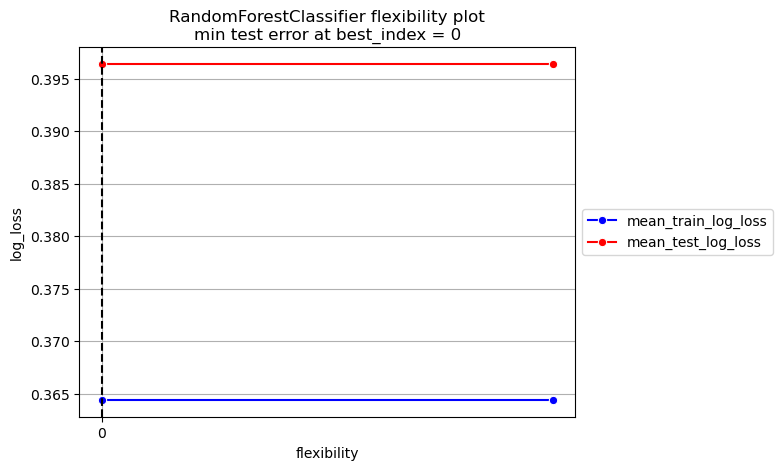

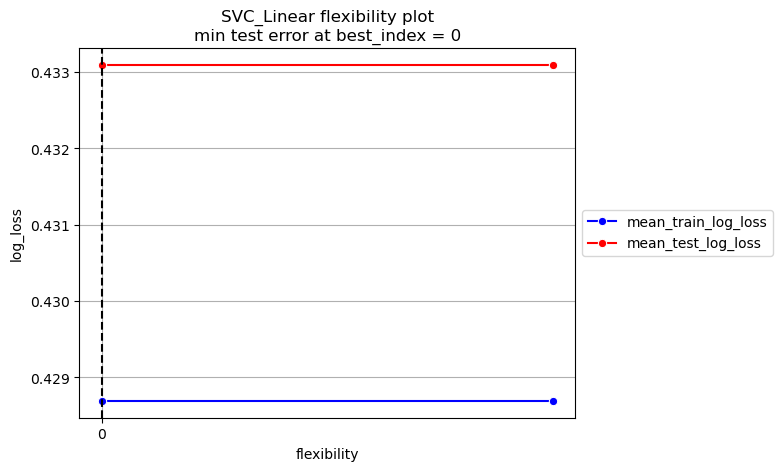

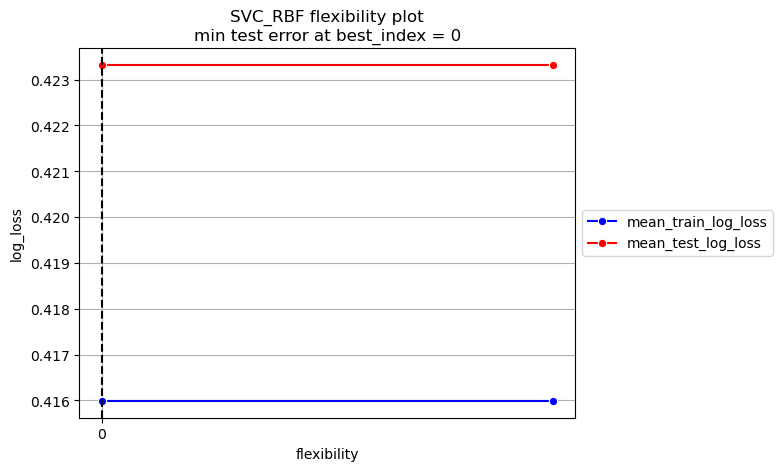

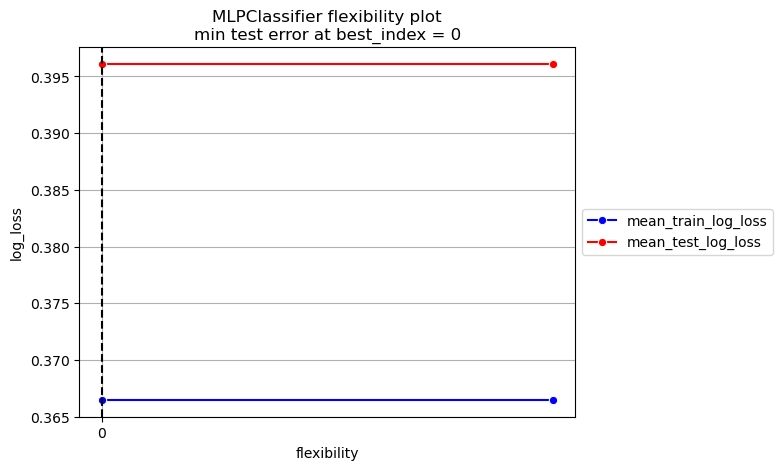

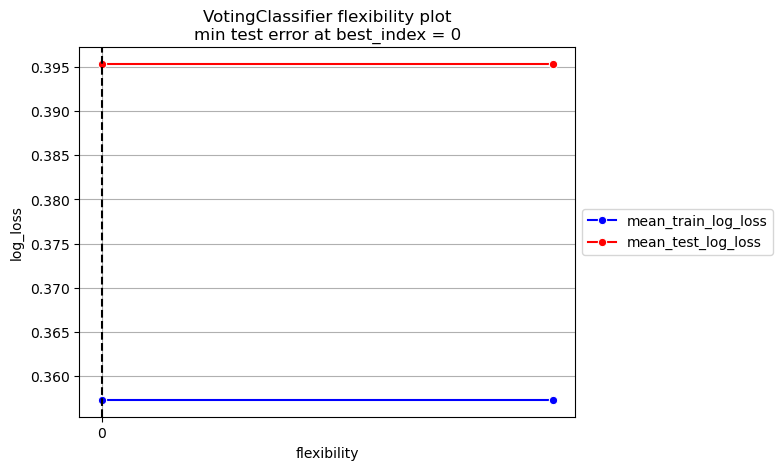

,estimator_name,score,best_test_score,best_index,grid_search_cv,gs_cv_results_df
0,VotingClassifier,neg_log_loss,0.395323,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
1,MLPClassifier,neg_log_loss,0.396103,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
2,RandomForestClassifier,neg_log_loss,0.396428,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
3,SVC_RBF,neg_log_loss,0.423320,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
4,SVC_Linear,neg_log_loss,0.433091,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...


In [42]:
gs_survey_results_df = pd.DataFrame()
for estimator_name, grid_search_cv in tuned_estimator_dict.items():
    print('\n\n')
    return_dict = sml_utils.plot_flexibility(
        grid_search_cv=grid_search_cv,
        estimator_name=estimator_name,
        scoring=scoring
    )
    results_df = return_dict['results_df']
    results_df['estimator_name'] = estimator_name
    results_df = results_df[['estimator_name'] + [attr for attr in results_df if attr not in ['estimator_name']]]
    gs_survey_results_df = pd.concat([gs_survey_results_df, results_df], axis=0)

gs_survey_results_df = gs_survey_results_df.sort_values(['score', 'best_test_score'])
gs_survey_results_df = gs_survey_results_df.reset_index(drop=True)
gs_survey_results_df

### alternative model selection - use gs_survey_results_df to pick an alternative model from the grid serach and add it to tuned_estimator_dict

In [43]:
explore_alt_model = False
add_alternative_model_to_flow = False

if explore_alt_model:
    
    %load_ext autoreload
    %autoreload 2
    
    return_dict = reg_ms_utils.alternative_model_selection(
        trained_estimator_dict, 
        tuned_estimator_dict,
        train_cap_x_df, 
        train_y_df,
        gs_survey_results_df,
        scoring,
        param_grids,
        demo_reg_flow=False,  # True = demo flow and False = develop algo to get alternative model
        estimator='AdaBoostClassifier',  # the estimator you want an alternative choice for
        frac_count=0.2,  # frac_count * number of grid points = how many gridpoints in a row the train and test bands are separated
        num_std=1.0,  # specifies the width of the train and test bands in units of std dev on flex plot
        man_flex_plot_index=250, # None,  # None  # = None means algo used - if integer then you must visually inspect flex plot and specify flex_index to get the hyperparameters of the model you want
        add_alternative_model_to_flow=add_alternative_model_to_flow
    )

    if add_alternative_model_to_flow:
        tuned_estimator_dict = return_dict['tuned_estimator_dict']
        gs_survey_results_df = return_dict['gs_survey_results_df']
        param_grids = return_dict['param_grids']

In [44]:
gs_survey_results_df

,estimator_name,score,best_test_score,best_index,grid_search_cv,gs_cv_results_df
0,VotingClassifier,neg_log_loss,0.395323,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
1,MLPClassifier,neg_log_loss,0.396103,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
2,RandomForestClassifier,neg_log_loss,0.396428,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
3,SVC_RBF,neg_log_loss,0.423320,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...
4,SVC_Linear,neg_log_loss,0.433091,0,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",index rank_test_neg_log_loss mean_train_n...


In [45]:
# gs_survey_results_df = gs_survey_results_df.loc[gs_survey_results_df.estimator_name != 'AlternativeRandomForestClassifier', :]
# gs_survey_results_df

## 15. evaluate (cost function and ranking metrics) tuned composite estimators

### use cross validation for model selection


            regressor_name score_name_ score_type     score
0           MLPClassifier    log_loss       test  0.401057
1           MLPClassifier    log_loss      train  0.369505
2  RandomForestClassifier    log_loss       test  0.394156
3  RandomForestClassifier    log_loss      train  0.364007
4              SVC_Linear    log_loss       test  0.434418
5              SVC_Linear    log_loss      train  0.428542
6                 SVC_RBF    log_loss       test  0.425086
7                 SVC_RBF    log_loss      train  0.415770
8        VotingClassifier    log_loss       test  0.396843
9        VotingClassifier    log_loss      train  0.358809 



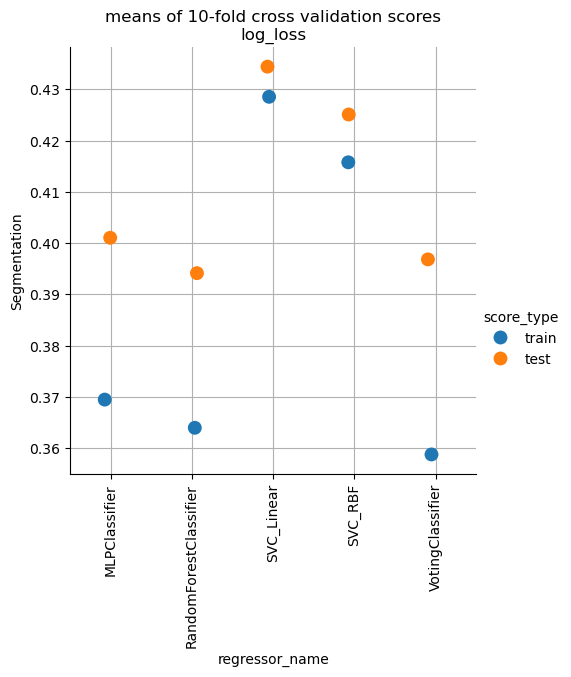

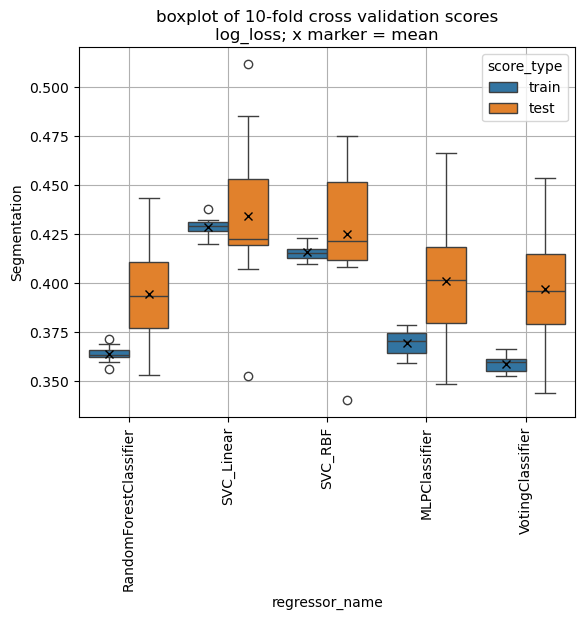

In [46]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=kfold_n_splits,
    shuffle=kfold_shuffle,
    random_state=kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# perform cross validation on models
sml_utils.model_tuning_cross_val_and_analysis(
    tuned_estimator_dict, 
    train_cap_x_df, 
    train_y_df, 
    scoring, 
    splitter, 
    target_attr,
    task=task
)

### get the ranking metrics


             regressor_name        score_name_ score_type     score
0            MLPClassifier  average_precision       test  0.890458
1            MLPClassifier  average_precision      train  0.905203
2            MLPClassifier            roc_auc       test  0.892320
3            MLPClassifier            roc_auc      train  0.907990
4   RandomForestClassifier  average_precision       test  0.889133
5   RandomForestClassifier  average_precision      train  0.908772
6   RandomForestClassifier            roc_auc       test  0.894026
7   RandomForestClassifier            roc_auc      train  0.914588
8               SVC_Linear  average_precision       test  0.874035
9               SVC_Linear  average_precision      train  0.875846
10              SVC_Linear            roc_auc       test  0.883342
11              SVC_Linear            roc_auc      train  0.886205
12                 SVC_RBF  average_precision       test  0.881513
13                 SVC_RBF  average_precision      train  0.

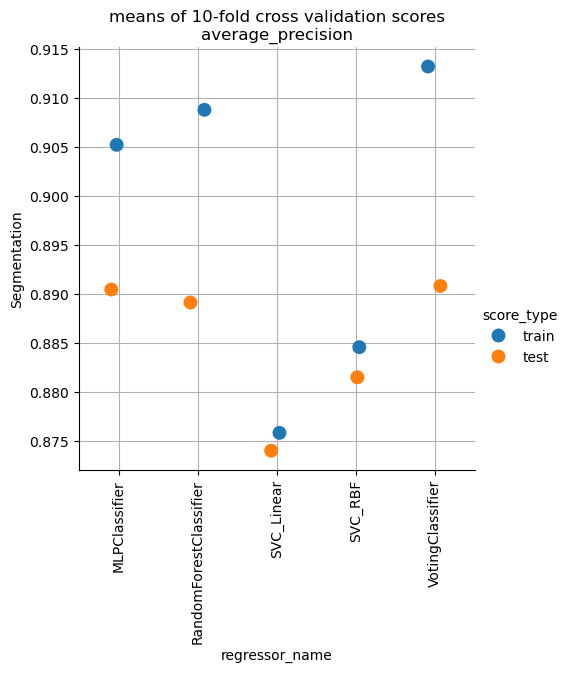

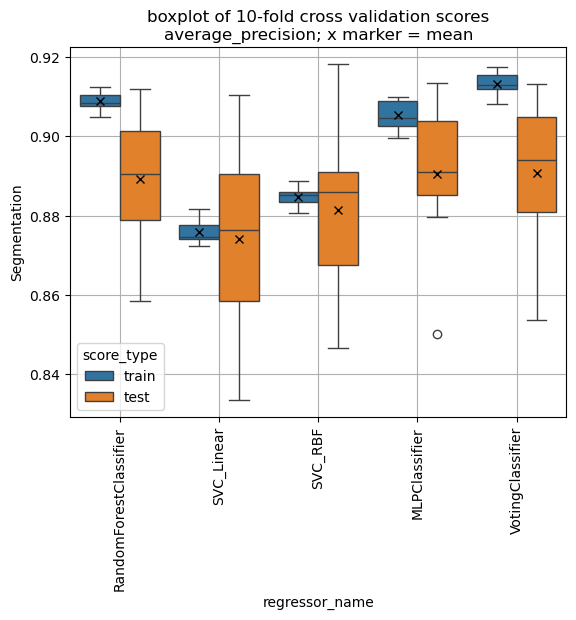

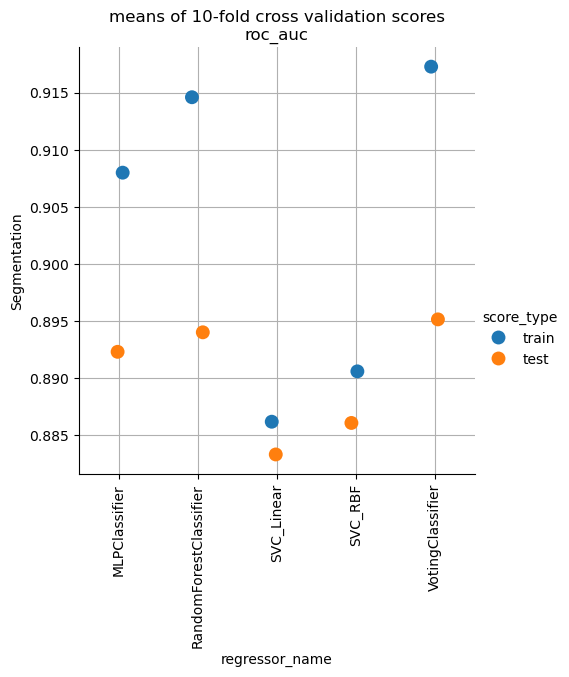

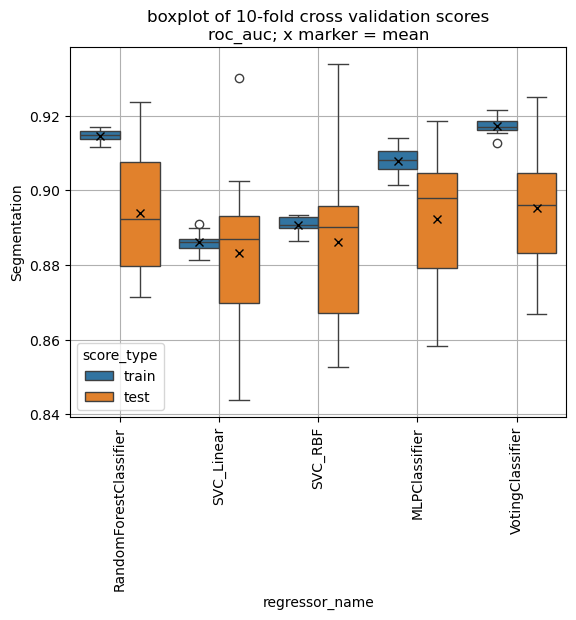

In [47]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=kfold_n_splits,
    shuffle=kfold_shuffle,
    random_state=kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# perform cross validation on models
return_dict = sml_utils.model_tuning_cross_val_and_analysis(
    tuned_estimator_dict=tuned_estimator_dict, 
    train_cap_x_df=train_cap_x_df, 
    train_y_df=train_y_df, 
    scoring=['average_precision', 'roc_auc'], 
    splitter=splitter, 
    target_attr=target_attr,
    task=task,
    return_=True
)
tuned_model_ranking_cv_scores_grouped_df = return_dict['cv_scores_grouped_df']

### check out the best estimator hyperparameters for each estimator

In [48]:
print('best hyperparameters for each estimator\n')

for index, row in gs_survey_results_df.iterrows():
    
    print(f'\nestimator_name: {row['estimator_name']}; score: {row['score']}')
    
    param_grids_ = param_grids[row['estimator_name']]
    for hyperparameter_name, hyperparameter_value in row['grid_search_cv'].best_params_.items():

        if len(param_grids_[hyperparameter_name]) > 1 and not show_all_params:  #  and only_show_searched_params:  # only check the hyperparameter you are varing
            print(f'   hyperparameter_name: {hyperparameter_name}; hyperparameter_value: {hyperparameter_value}')
        elif show_all_params:
            print(f'   hyperparameter_name: {hyperparameter_name}; hyperparameter_value: {hyperparameter_value}')

best hyperparameters for each estimator


estimator_name: VotingClassifier; score: neg_log_loss
   hyperparameter_name: estimator__MLPClassifier__activation; hyperparameter_value: relu
   hyperparameter_name: estimator__MLPClassifier__alpha; hyperparameter_value: 0.0001
   hyperparameter_name: estimator__MLPClassifier__hidden_layer_sizes; hyperparameter_value: (100,)
   hyperparameter_name: estimator__MLPClassifier__learning_rate; hyperparameter_value: adaptive
   hyperparameter_name: estimator__MLPClassifier__learning_rate_init; hyperparameter_value: 0.01
   hyperparameter_name: estimator__MLPClassifier__max_iter; hyperparameter_value: 500
   hyperparameter_name: estimator__MLPClassifier__solver; hyperparameter_value: adam
   hyperparameter_name: estimator__RandomForestClassifier__max_depth; hyperparameter_value: 17
   hyperparameter_name: estimator__RandomForestClassifier__max_features; hyperparameter_value: sqrt
   hyperparameter_name: estimator__RandomForestClassifier__max_samples;

In [49]:
# get the minimum test score from the GridSeachCV

min_test_score = gs_survey_results_df.best_test_score.min()
print(f'\nMinimum test score from GridSearchCV: {min_test_score}')

# get the name of the estimator with the minimum test score
estimator_name = gs_survey_results_df.loc[gs_survey_results_df['best_test_score'] == min_test_score, 'estimator_name'].iloc[0]
print(f'\nThe estimator with minimum test score from GridSearchCV is considered the best model. It is: {estimator_name}')

# get the best estimator
best_model_name = gs_survey_results_df.loc[gs_survey_results_df['best_test_score'] == min_test_score, 'estimator_name'].values[0]
best_model = gs_survey_results_df.loc[gs_survey_results_df['best_test_score'] == min_test_score, 'grid_search_cv'].values[0].best_estimator_

print(f'\nNote that the best estimator from a GridSearchCV is not necessarily the best model.\n'
      f'\nThe best model will come from a GridSearchCV that was conducted with a parameter grid\n'
      f'that covered the range of parameters to give the best model.\n'
      f'\nTypically several GridSearchCV runs are required to assure yourself the the range of\n'
      f'parameters can give the best model')


Minimum test score from GridSearchCV: 0.39532310519281005

The estimator with minimum test score from GridSearchCV is considered the best model. It is: VotingClassifier

Note that the best estimator from a GridSearchCV is not necessarily the best model.

The best model will come from a GridSearchCV that was conducted with a parameter grid
that covered the range of parameters to give the best model.

Typically several GridSearchCV runs are required to assure yourself the the range of
parameters can give the best model


### evaluate tuned composite estimators

In [50]:
log_loss_best_model_on_train_set = log_loss(train_y_df, best_model.predict_proba(train_cap_x_df))

print(f'best_model is the trained estimator that performed the best in GridSearchCV.\n'
      f'\nIt was trained on the whole train set using the hyperparameter combination\n'
      f'that gave the lowest estimate of test error rate in cross validation.\n'
      f'\nThe log loss of the best_model when prediction on the whole train set is {log_loss_best_model_on_train_set}.')

best_model is the trained estimator that performed the best in GridSearchCV.

It was trained on the whole train set using the hyperparameter combination
that gave the lowest estimate of test error rate in cross validation.

The log loss of the best_model when prediction on the whole train set is 0.3567959573650517.


## beyond this point we will start using portions of an older code base so this is cell is dedicated to meeting the requirments of that code base

In [51]:
grid_search_cv_results_df = gotn.prep_gs_survey_results_df_for_calibration(gs_survey_results_df, tuned_model_ranking_cv_scores_grouped_df)
grid_search_cv_results_df

,iteration,estimator,ave_precision_score,roc_auc_score_,best_estimator,best_estimator_hyperparameters
0,1,MLPClassifier,0.890458,0.892320,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__activation': 'relu', 'estimator__..."
1,2,RandomForestClassifier,0.889133,0.894026,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__max_depth': 7, 'estimator__max_fe..."
2,4,SVC_Linear,0.874035,0.883342,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 0.89, 'estimator__class_weigh..."
3,3,SVC_RBF,0.881513,0.886098,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 621.0169418915616, 'estimator..."
4,0,VotingClassifier,0.890814,0.895157,"(ColumnTransformer(transformers=[('nominal',\n...",{'estimator__MLPClassifier__activation': 'relu...


## 16. calibrate classifier if required


************************************************************
************************************************************
************************************************************
************************************************************
calibration_data_set: first half of prob_cal_set_df
validation_data_set: second half of prob_cal_set_df
model_selection_stage: tuned
method: isotonic
ensemble: True



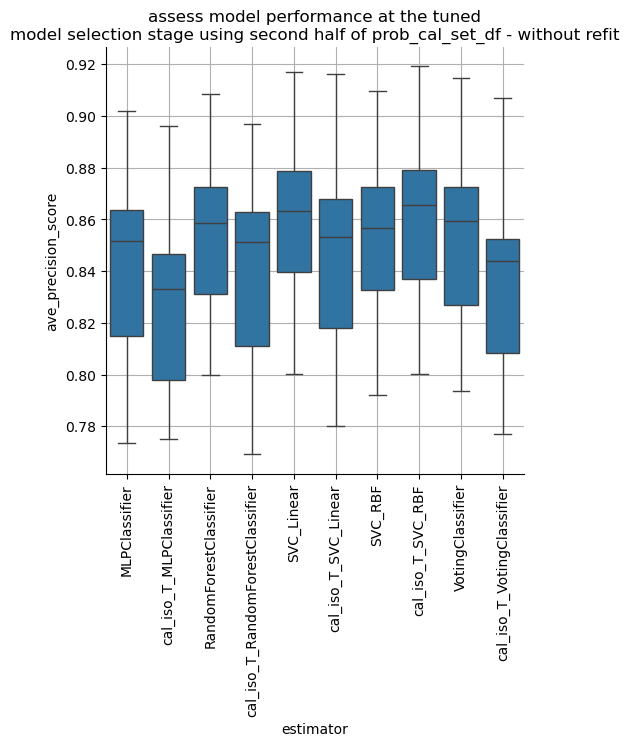

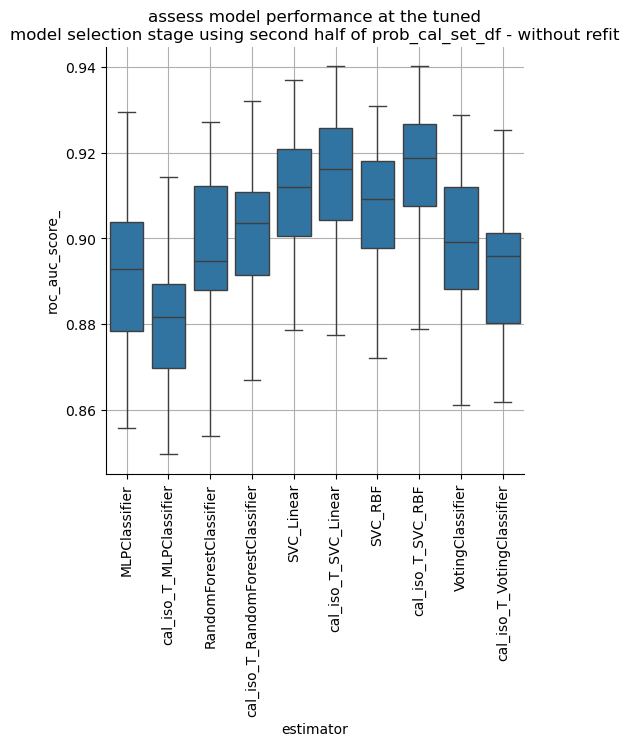

assess model performance at the tuned model selection stage using second half of prob_cal_set_df - without refit
confidence level of the confidence interval: 0.95

                           estimator            attr_name  norm_p_val      mean       low      high
0                      MLPClassifier  ave_precision_score    0.643057  0.839012  0.823015  0.853150
2            cal_iso_T_MLPClassifier  ave_precision_score    0.904260  0.826277  0.812828  0.840528
4             RandomForestClassifier  ave_precision_score    0.779224  0.853077  0.840052  0.865940
6   cal_iso_T_RandomForestClassifier  ave_precision_score    0.543118  0.839885  0.824168  0.853951
8                         SVC_Linear  ave_precision_score    0.737421  0.858747  0.845823  0.870518
10              cal_iso_T_SVC_Linear  ave_precision_score    0.791582  0.844358  0.829144  0.859614
12                           SVC_RBF  ave_precision_score    0.719167  0.851606  0.838390  0.863612
14                 cal_iso_T_SVC_RBF

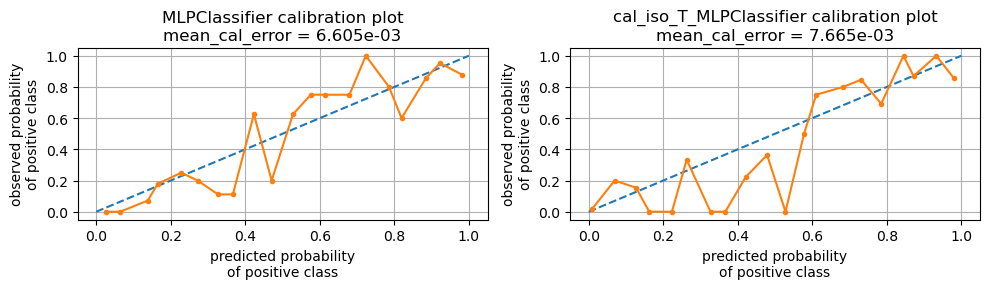


************************************************************
************************************************************
************************************************************
************************************************************
RandomForestClassifier  and  cal_iso_T_RandomForestClassifier

calibration_data_set: first half of prob_cal_set_df
validation_data_set: second half of prob_cal_set_df
model_selection_stage: tuned
method: isotonic
ensemble: True



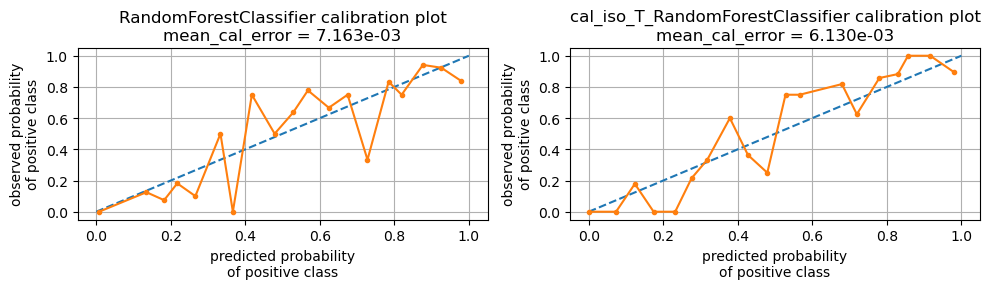


************************************************************
************************************************************
************************************************************
************************************************************
SVC_Linear  and  cal_iso_T_SVC_Linear

calibration_data_set: first half of prob_cal_set_df
validation_data_set: second half of prob_cal_set_df
model_selection_stage: tuned
method: isotonic
ensemble: True



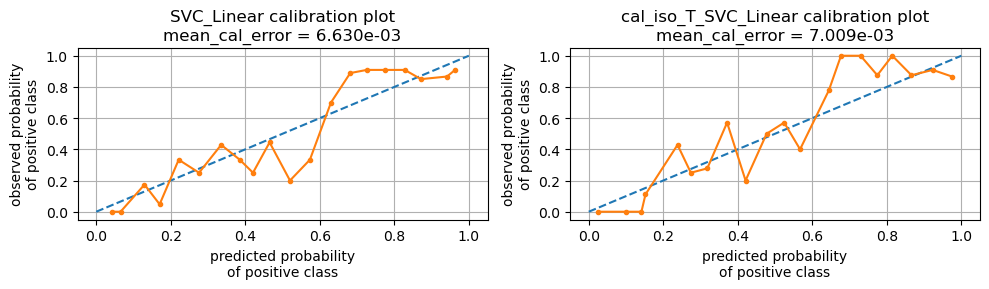


************************************************************
************************************************************
************************************************************
************************************************************
SVC_RBF  and  cal_iso_T_SVC_RBF

calibration_data_set: first half of prob_cal_set_df
validation_data_set: second half of prob_cal_set_df
model_selection_stage: tuned
method: isotonic
ensemble: True



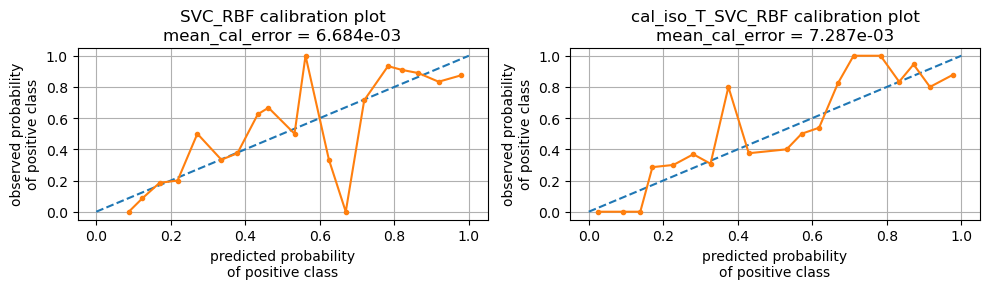


************************************************************
************************************************************
************************************************************
************************************************************
VotingClassifier  and  cal_iso_T_VotingClassifier

calibration_data_set: first half of prob_cal_set_df
validation_data_set: second half of prob_cal_set_df
model_selection_stage: tuned
method: isotonic
ensemble: True



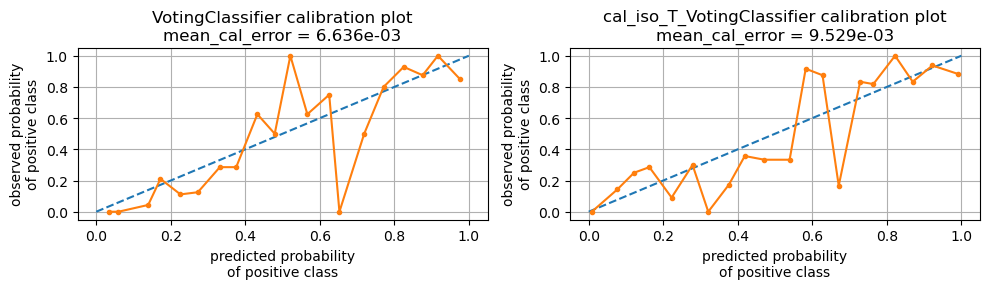

,iteration,estimator,ave_precision_score,roc_auc_score_,best_estimator,best_estimator_hyperparameters
0,0,cal_iso_T_MLPClassifier,0.829340,0.884577,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
1,1,cal_iso_T_RandomForestClassifier,0.840006,0.903993,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
2,2,cal_iso_T_SVC_Linear,0.847741,0.914819,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
3,3,cal_iso_T_SVC_RBF,0.859587,0.916038,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
4,4,cal_iso_T_VotingClassifier,0.838613,0.895925,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
0,1,MLPClassifier,0.890458,0.892320,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__activation': 'relu', 'estimator__..."
1,2,RandomForestClassifier,0.889133,0.894026,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__max_depth': 7, 'estimator__max_fe..."
2,4,SVC_Linear,0.874035,0.883342,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 0.89, 'estimator__class_weigh..."
3,3,SVC_RBF,0.881513,0.886098,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 621.0169418915616, 'estimator..."
4,0,VotingClassifier,0.890814,0.895157,"(ColumnTransformer(transformers=[('nominal',\n...",{'estimator__MLPClassifier__activation': 'relu...


In [52]:
if calibrate_classifiers:
    
    # class_eval_dict:
    #    key = name of function in classification_utils.py
    #    value = [bool, function kwargs]  bool = True then call function
    print_plots = False
    binary = True
    class_eval_dict={
        'binary': binary,
        'scoring': 'average_precision',
        'get_precision_recall_curves': [True, 
                                            {
                                                'print_prc': print_plots, 
                                                'print_prd': print_plots,
                                            }
                                       ],
        'get_roc_curve': [True, 
                              {
                                  'print_roc': print_plots,
                              }
                         ]
    }

    # load the data for probability calibration
    prob_cal_set_df = pd.read_csv('prob_cal_set_df.csv').set_index(keys='index')
    prob_cal_set_df.index.name = None
    prob_cal_set_cap_x_df, prob_cal_set_y_df = prob_cal_set_df.iloc[:, :-1], prob_cal_set_df.iloc[:, -1].to_frame()
    cal_count = int(frac_of_val_for_cal * prob_cal_set_cap_x_df.shape[0])
    cal_val_count = prob_cal_set_cap_x_df.shape[0] - cal_count

    # calibrate the probability
    cal_grid_search_cv_results_df = al_utils.calibrate_estimators(
        estimator_names=grid_search_cv_results_df.estimator.to_list(),  # list(tuned_estimator_dict.keys()), 
        grid_search_cv_results_df=grid_search_cv_results_df,
        cal_cap_x_df=prob_cal_set_cap_x_df.iloc[:cal_count,:],  # calibrate on unseen data
        cal_y_df=prob_cal_set_y_df.iloc[:cal_count,:],  # calibrate on unseen data
        calibration_data_set_name='first half of prob_cal_set_df', 
        validation_cap_x_df=prob_cal_set_cap_x_df.iloc[cal_count:,:],  # use unseen data to validate calibration 
        validation_y_df=prob_cal_set_y_df.iloc[cal_count:,:],  # use unseen data to validate calibration 
        validation_data_set_name='second half of prob_cal_set_df',
        class_eval_dict=class_eval_dict,
        model_selection_stage='tuned', 
        method='isotonic',  # 'sigmoid' or 'isotonic'
        ensemble=True
    )

    # clean up estimator names
    estimator_names = al_utils.get_estimator_names_helper(
        grid_search_cv_results_df, 
        cal_grid_search_cv_results_df
    )

    # add probability calibration data to the data frame
    grid_search_cv_results_df = pd.concat([cal_grid_search_cv_results_df, grid_search_cv_results_df], axis=0)

del prob_cal_set_df, prob_cal_set_cap_x_df, prob_cal_set_y_df

grid_search_cv_results_df

## the resampling method in old code base is validation data set method. in the new code base we use k-fold cross validation. we will replace the numbers from the old method with numbers from the new method for consistency


                       regressor_name        score_name_ score_type     score
0                      MLPClassifier  average_precision       test  0.890458
1                      MLPClassifier  average_precision      train  0.905203
2                      MLPClassifier            roc_auc       test  0.892320
3                      MLPClassifier            roc_auc      train  0.907990
4             RandomForestClassifier  average_precision       test  0.889133
5             RandomForestClassifier  average_precision      train  0.908772
6             RandomForestClassifier            roc_auc       test  0.894026
7             RandomForestClassifier            roc_auc      train  0.914588
8                         SVC_Linear  average_precision       test  0.874035
9                         SVC_Linear  average_precision      train  0.875846
10                        SVC_Linear            roc_auc       test  0.883342
11                        SVC_Linear            roc_auc      train  0.8862

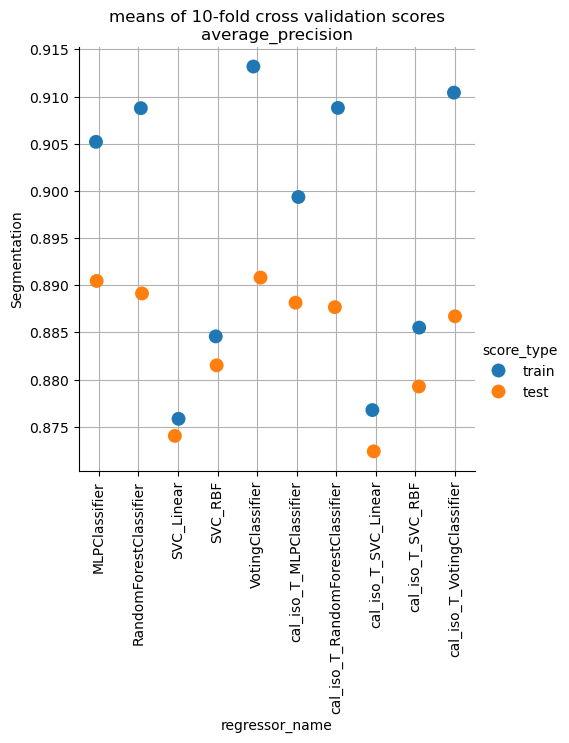

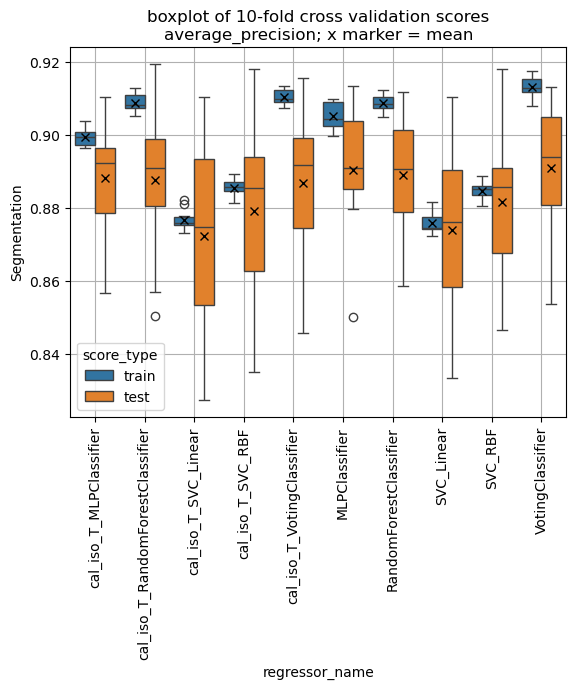

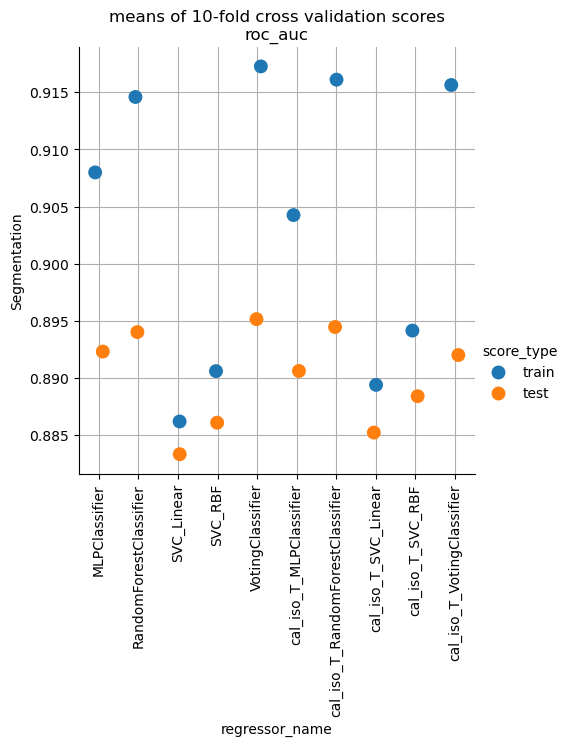

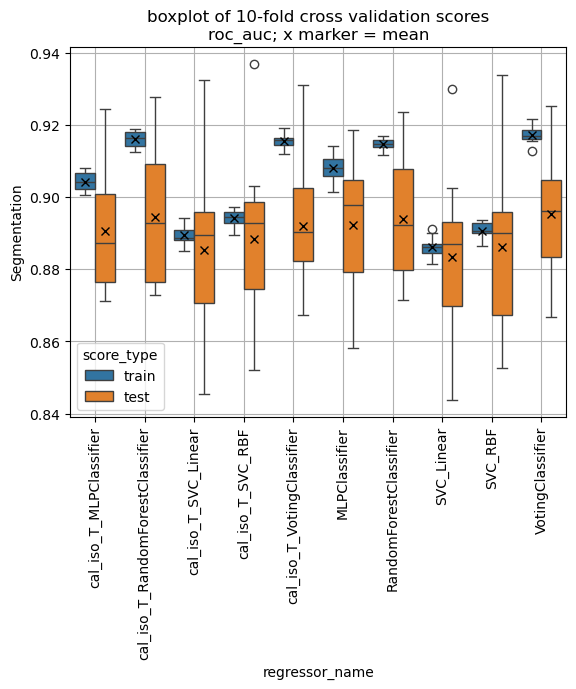

,iteration,estimator,ave_precision_score,roc_auc_score_,best_estimator,best_estimator_hyperparameters
0,1,MLPClassifier,0.890458,0.892320,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__activation': 'relu', 'estimator__..."
1,2,RandomForestClassifier,0.889133,0.894026,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__max_depth': 7, 'estimator__max_fe..."
2,4,SVC_Linear,0.874035,0.883342,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 0.89, 'estimator__class_weigh..."
3,3,SVC_RBF,0.881513,0.886098,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 621.0169418915616, 'estimator..."
4,0,VotingClassifier,0.890814,0.895157,"(ColumnTransformer(transformers=[('nominal',\n...",{'estimator__MLPClassifier__activation': 'relu...
5,0,cal_iso_T_MLPClassifier,0.888155,0.890622,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
6,1,cal_iso_T_RandomForestClassifier,0.887681,0.894468,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
7,2,cal_iso_T_SVC_Linear,0.872395,0.885235,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
8,3,cal_iso_T_SVC_RBF,0.879270,0.888418,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
9,4,cal_iso_T_VotingClassifier,0.886711,0.892017,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."


In [53]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=kfold_n_splits,
    shuffle=kfold_shuffle,
    random_state=kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# perform cross validation on models
return_dict = sml_utils.model_tuning_cross_val_and_analysis(
    tuned_estimator_dict=dict(zip(grid_search_cv_results_df.estimator, grid_search_cv_results_df.best_estimator)),
    train_cap_x_df=train_cap_x_df, 
    train_y_df=train_y_df, 
    scoring=['average_precision', 'roc_auc'], 
    splitter=splitter, 
    target_attr=target_attr,
    task=task,
    return_=True
)
tuned_model_ranking_cv_scores_grouped_df = return_dict['cv_scores_grouped_df']

grid_search_cv_results_df = gotn.add_ave_precision_and_roc_auc(grid_search_cv_results_df, tuned_model_ranking_cv_scores_grouped_df)
grid_search_cv_results_df

## 17. check for false discoveries

### shuffle the target and do cross validation to understand if we have a real or false discovery


            regressor_name score_name_ score_type     score
0           MLPClassifier    log_loss       test  0.704506
1           MLPClassifier    log_loss      train  0.682347
2  RandomForestClassifier    log_loss       test  0.696541
3  RandomForestClassifier    log_loss      train  0.677003
4              SVC_Linear    log_loss       test  0.690178
5              SVC_Linear    log_loss      train  0.689127
6                 SVC_RBF    log_loss       test  0.688367
7                 SVC_RBF    log_loss      train  0.688357
8        VotingClassifier    log_loss       test  0.695910
9        VotingClassifier    log_loss      train  0.670249 





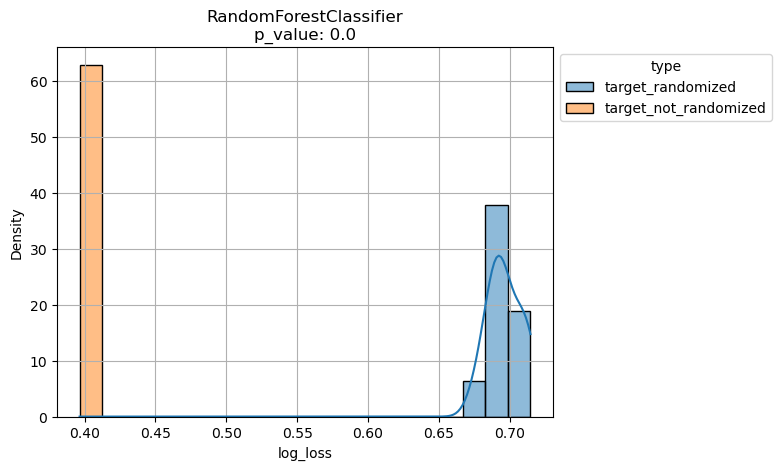

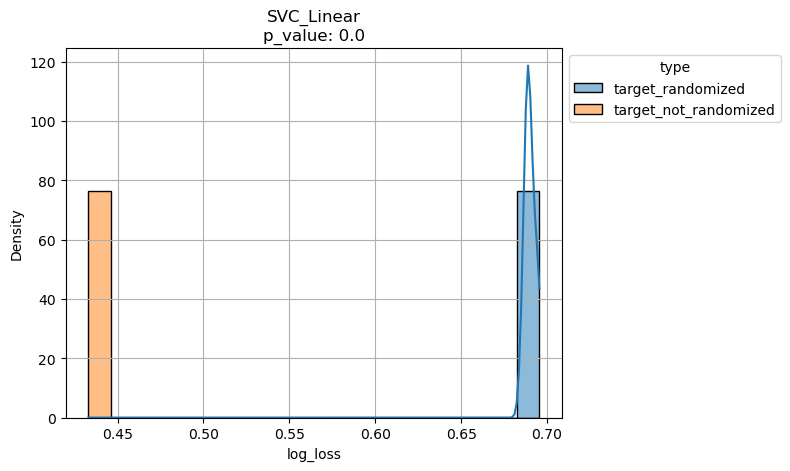

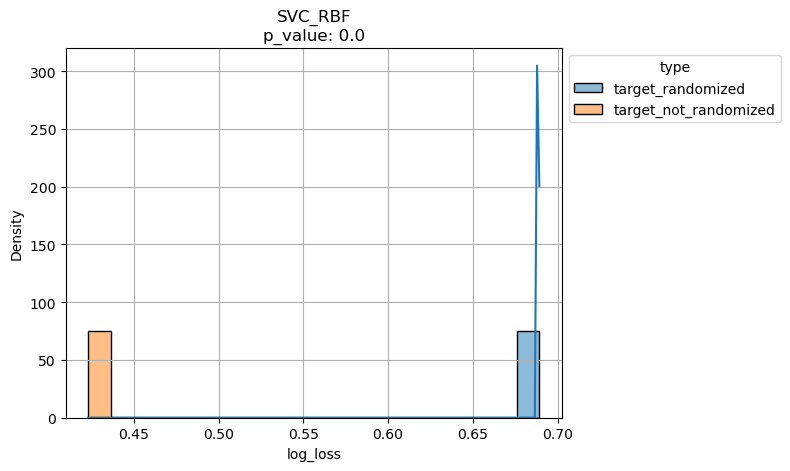

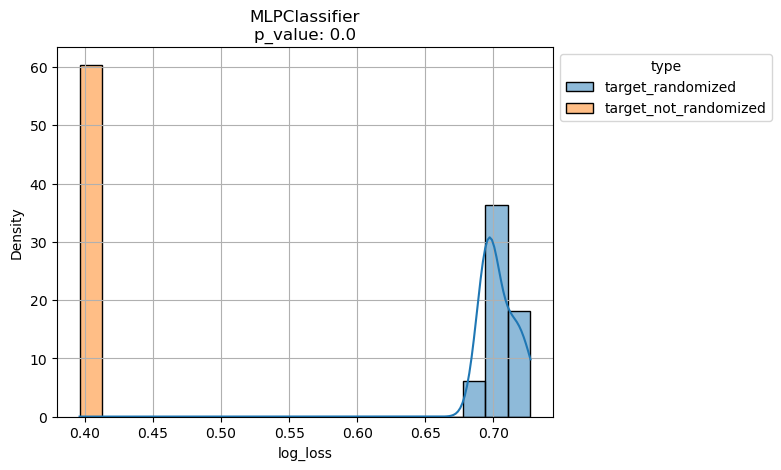

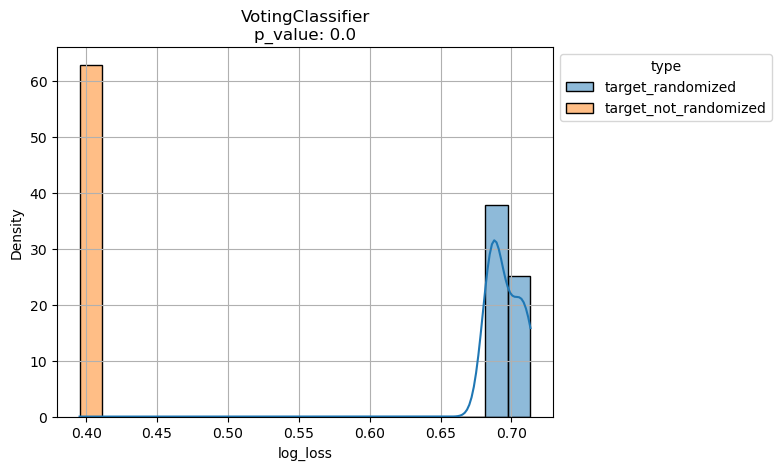

In [54]:
sml_utils.check_for_false_discoveries(
    tuned_estimator_dict, 
    train_cap_x_df, 
    train_y_df, 
    scoring, 
    splitter, 
    target_attr, 
    shuffle_target=True,
    shuffle_target_random_state=42, 
    gs_survey_results_df=gs_survey_results_df,
    task=task
)

## 18. select a model

In [55]:
composite_estimator = None

### You can let the script select the best model by setting composite_estimator = best_model below. This will select the model with the lowest log loss coming out of GridSearchCV. This is done in cell 43.

### Or you can hand select the model you want to promote from the list of models below. 

### This is helpful if you want to select a model based on average precision or roc auc. It is also helpful if you want to select a model that has had its probability calibrated.

In [56]:
grid_search_cv_results_df

,iteration,estimator,ave_precision_score,roc_auc_score_,best_estimator,best_estimator_hyperparameters
0,1,MLPClassifier,0.890458,0.892320,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__activation': 'relu', 'estimator__..."
1,2,RandomForestClassifier,0.889133,0.894026,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__max_depth': 7, 'estimator__max_fe..."
2,4,SVC_Linear,0.874035,0.883342,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 0.89, 'estimator__class_weigh..."
3,3,SVC_RBF,0.881513,0.886098,"(ColumnTransformer(transformers=[('nominal',\n...","{'estimator__C': 621.0169418915616, 'estimator..."
4,0,VotingClassifier,0.890814,0.895157,"(ColumnTransformer(transformers=[('nominal',\n...",{'estimator__MLPClassifier__activation': 'relu...
5,0,cal_iso_T_MLPClassifier,0.888155,0.890622,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
6,1,cal_iso_T_RandomForestClassifier,0.887681,0.894468,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
7,2,cal_iso_T_SVC_Linear,0.872395,0.885235,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
8,3,cal_iso_T_SVC_RBF,0.879270,0.888418,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."
9,4,cal_iso_T_VotingClassifier,0.886711,0.892017,"CalibratedClassifierCV(cv=5,\n ...","{'cv': 5, 'ensemble': True, 'estimator__memory..."


In [57]:
print(f'currently the best model name based on log loss coming out of GridSearchCV is {best_model_name}')

currently the best model name based on log loss coming out of GridSearchCV is VotingClassifier


In [58]:
if script_select:
    print(f'you have opted for using the best_model and best_model_name assigned in cell 47 using log loss of uncalibrated '
          f'model')
elif hand_select:
    if hand_select_index is None or hand_select_index not in grid_search_cv_results_df.index:
        sys.exit(f'{hand_select_index} is not a valid index - go to cell 5 line 69 and enter a valid grid_search_cv_results_df'
                 f' index to indicate the model you want to select')
    else:
        best_model_name = grid_search_cv_results_df.loc[hand_select_index, 'estimator']
        best_model = grid_search_cv_results_df.loc[hand_select_index, 'best_estimator']
else:
    sys.exit(f'go to cell 5 lines 65 to 69 to set up model selection')

print(f'\nthe best model name is {best_model_name}')

SystemExit: go to cell 5 lines 65 to 69 to set up model selection

/Users/nelsonfarrell/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 19. tune classification threshold

### scan over classification thresholds and pick the threshold that minimizes the most costly errors - recall or precision

In [ ]:
class_thresh_set_df = pd.read_csv('class_thresh_set_df.csv').set_index(keys='index')
class_thresh_set_df.index.name = None
class_thresh_set_cap_x_df, class_thresh_set_y_df = class_thresh_set_df.iloc[:, :-1], class_thresh_set_df.iloc[:, -1].to_frame()

In [ ]:
class_threshold_list = np.arange(0, 1.1, 0.1)
thresh_class_perf_dict = \
    class_utils_2.class_thresh_metrics_class_perf_assess_binary(
        best_model_name=best_model_name, 
        estimator_names=estimator_names, 
        grid_search_cv_results_df=grid_search_cv_results_df, 
        cap_x_df=class_thresh_set_cap_x_df, 
        y_df=class_thresh_set_y_df, 
        class_threshold_list=class_threshold_list, 
        cvs_compute=False, 
        cvs_print=False, 
        data_set_name='class_thresh_set_df', 
        model_selection_stage='tuned'
)

In [ ]:
class_threshold_list = np.arange(0, 1.01, 0.01)
class_utils_2.plot_errors_as_a_function_of_classification_threshold(
    best_model_name=best_model_name, 
    estimator_names=estimator_names, 
    grid_search_cv_results_df=grid_search_cv_results_df, 
    cap_x_df=class_thresh_set_cap_x_df, 
    y_df=class_thresh_set_y_df, 
    class_threshold_list=class_threshold_list, 
    data_set_name='class_thresh_set_df',
    model_selection_stage='tuned'
)

### use bootstrapping to understand how metrics will vary for future data sets from the same data generation process

In [ ]:
if classification_threshold is None:
    sys.exit(f'{classification_threshold} is not a valid classification threshold - go to cell 5 line 72 to set a classification threshold')
else:
    print(f'the classification threshold is {classification_threshold}')

In [ ]:
class_utils_2.precision_recall_bootstrap_no_refit_binary(
    best_model_name=best_model_name,
    estimator_names=estimator_names, 
    grid_search_cv_results_df=grid_search_cv_results_df,
    cap_x_df=class_thresh_set_cap_x_df,
    y_df=class_thresh_set_y_df, 
    n_bootstrap=20,
    data_set_name='class_thresh_set_df', 
    model_selection_stage='tuned',
    classification_threshold=classification_threshold
)

In [ ]:
class_utils_2.roc_curve_bootstrap_no_refit_binary(
    best_model_name=best_model_name,
    estimator_names=estimator_names, 
    grid_search_cv_results_df=grid_search_cv_results_df, 
    cap_x_df=class_thresh_set_cap_x_df, 
    y_df=class_thresh_set_y_df, 
    n_bootstrap=20,
    data_set_name='class_thresh_set_df', 
    model_selection_stage='tuned',
    classification_threshold=classification_threshold
)

### take a final look at this models performance when tuned to the classification threshold

In [ ]:
class_perf_dict = class_utils_2.classification_performance(
    trained_classifier=best_model, 
    cap_x_df=class_thresh_set_cap_x_df, 
    y_df=class_thresh_set_y_df.values.ravel(), 
    classification_threshold=classification_threshold,
    binary=True,
    # https://scikit-learn.org/stable/modules/model_evaluation.html
    cvs_scoring_dict={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    },
    cr_digits=4,
    cr_print=True,  # print classification report
    cm_print=True,  # print confusion matrix
    cvs_compute=False,  # compute cross_val_scores (classification threshold = 0.5 always)
    cvs_print=True,  # print cross_val_scores (classification threshold = 0.5 always) - ignored if cvs_compute=False
    prc_print=True,  # print precision and recall curves as a function of classification threshold
    prd_print=True,  # print precision recall curves
    roc_print=True,  # print roc curve
    data_set_name='class_thresh_set_df', 
    model_selection_stage='tuned'
)

In [ ]:
del class_thresh_set_df, class_thresh_set_cap_x_df, class_thresh_set_y_df

## serialize model and classification threshold

In [ ]:
now = datetime.datetime.now()
date_time_prefix = str(now).replace('-', '_').replace(' ', '_').replace(':', '_').replace('.', '_')[:-4]

date_time_prefix

In [ ]:
best_estimator_file_name = date_time_prefix + '_model' + '.pkl'

best_estimator_file_name

In [ ]:
# best_estimator = \
#     grid_search_cv_results_df.loc[grid_search_cv_results_df.estimator == best_model, 'best_estimator'].iloc[0]

model_dict = {
    'classification_threshold': classification_threshold,
    'best_model_name': best_model_name,
    'best_model': best_model
}

In [ ]:
with open(best_estimator_file_name, 'wb') as f:
    pickle.dump(model_dict, f)

## evaluate model on the test set

This should be done in an independent notebook.

## check out script run time

In [ ]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')